# Analysis of CLIP similarities on one movie

In [89]:
import sys
sys.path.append("/home/simon/mount/astranaar/moment_detr")
import os
from IPython.utils import io
import numpy as np
from matplotlib import pyplot as plt

import torch

from moment_detr.config import BaseOptions
from moment_detr.transformer import build_transformer
from moment_detr.position_encoding import build_position_encoding
from moment_detr.clip_similarity import clip_filter_proposals
from moment_detr.setup_clip_training import setup_training, set_seed, data_to_device



In [2]:
with io.capture_output() as captured:
    opt = BaseOptions()
    opt.initialize()
    opt = opt.parse()
local_root = '/home/simon/mount/data/'

opt.train_path = os.path.join(local_root, 'mad_dataset/annotations/MAD_train.json')
opt.eval_path_long_nlq = os.path.join(local_root, 'mad_dataset/annotations/MAD_test.json')
opt.eval_path = os.path.join(local_root, 'mad_dataset/annotations/MAD_val.json')
opt.t_feat_dir = os.path.join(local_root, 'mad_dataset/')
opt.v_feat_dirs = [os.path.join(local_root, 'mad_dataset/')]
#opt.resume = os.path.join(local_root, 'mad_dataset/momentDETR_results/CLIP_L14_bsz256_lr1e-4_dr1_wl30_fps5_lws4_lloss4_closs4_ret_tok_prop/model_best.ckpt')
opt.resume = None
opt.concat_sims = False

model, criterion, optimizer, lr_scheduler, opt, train_loader, val_loader = setup_training(mode='train', opt=opt, batch_size=1, num_workers=1,use_clip_prefiltering=False)
dataloader = iter(train_loader)

2023-01-20 11:00:33.231:INFO:moment_detr.inference - setup model/optimizer/scheduler
2023-01-20 11:00:34.019:INFO:moment_detr.inference - CUDA enabled.
2023-01-20 11:00:34.027:WARNING:moment_detr.inference - If you intend to evaluate the model, please specify --resume with ckpt path
2023-01-20 11:00:34.028:INFO:moment_detr.setup_clip_training - Model MomentDETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)


Parameter Count: all 4,403,977; trainable 4,403,977


2023-01-20 11:00:36.474:INFO:moment_detr.long_nlq_dataset - LOADING: /home/simon/mount/data/mad_dataset/CLIP_L14_language_tokens_features.h5
2023-01-20 11:00:36.507:INFO:moment_detr.long_nlq_dataset - LOADING: /home/simon/mount/data/mad_dataset/CLIP_L14_frames_features_5fps.h5
2023-01-20 11:00:36.542:INFO:moment_detr.long_nlq_dataset - LOADING: /home/simon/mount/data/mad_dataset/annotations/MAD_val.json


In [206]:
batch = next(dataloader)
target, data, qid, windows = batch
clip_metrics = {}
_data, _target, windows, metrics, sims = clip_filter_proposals(data[0],target[0],7,300,clip_metrics,windows[0],-1)
movie = data[0]['src_vid']
topk_movie = _data['src_vid']
topk_target = _target

In [145]:
t = topk_target['is_foreground'].argmax().item()
rounded_frames_idx = [round(t*5) for t in target[0]['anno']['ext_timestamps']]

start_end_relative_to_window = [r-w for r,w in zip(rounded_frames_idx, windows[t])]
middle_frame = int(np.mean(rounded_frames_idx) -rounded_frames_idx[0])
start_end_frames = [_data['src_vid'][t][i] for i in start_end_relative_to_window]
middle_frame = _data['src_vid'][t][middle_frame]

In [134]:
middle_frame.shape

torch.Size([770])

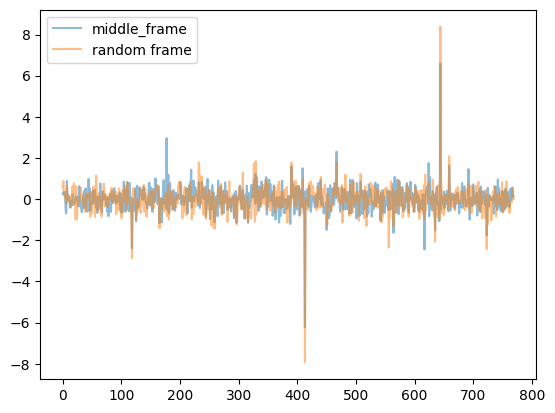

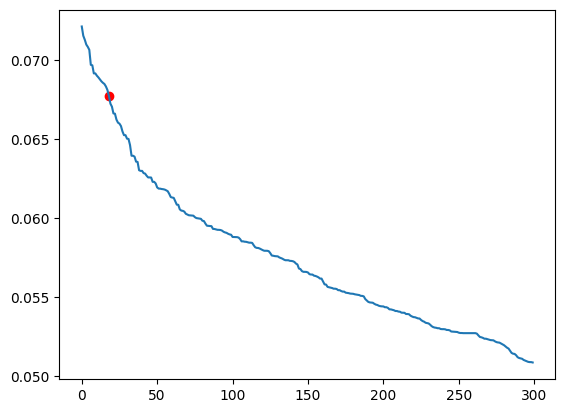

In [147]:
#labels = ['start frame','end frame', 'middle_frame', 'random frame']
labels = ['middle_frame', 'random frame']
for idx, frame in enumerate([middle_frame, _data['src_vid'][20][0]]):
    plt.plot(frame, label = labels[idx], alpha=0.5)
plt.legend(), plt.show()

plt.plot(sims)
for t in torch.where(topk_target['is_foreground']==1)[0]:
    plt.scatter(t, sims[t], c='red')
plt.show()

In [209]:
data[0]

{'src_vid': tensor([[[ 0.8193,  1.4473,  0.0353,  ...,  0.1910,  0.0000,  0.0067],
          [ 0.9409,  1.4121, -0.1260,  ...,  0.2173,  0.0067,  0.0133],
          [ 1.0488,  1.5342,  0.0934,  ...,  0.1860,  0.0133,  0.0200],
          ...,
          [ 0.4919,  1.2344,  0.1429,  ...,  0.2142,  0.9800,  0.9867],
          [ 0.3140,  1.1504, -0.1963,  ...,  0.2048,  0.9867,  0.9933],
          [ 0.4048,  0.8979,  0.0077,  ...,  0.4102,  0.9933,  1.0000]],
 
         [[ 0.4082,  1.4189,  0.2189,  ...,  0.3169,  0.0000,  0.0067],
          [ 1.2441,  0.7158,  0.0409,  ...,  0.5142,  0.0067,  0.0133],
          [ 1.3154,  0.5938, -0.0979,  ...,  0.4426,  0.0133,  0.0200],
          ...,
          [ 0.7505,  0.8818,  0.6211,  ...,  0.3193,  0.9800,  0.9867],
          [ 0.7876,  0.9321,  0.7524,  ...,  0.4570,  0.9867,  0.9933],
          [ 0.9243,  0.7954,  0.6982,  ...,  0.3486,  0.9933,  1.0000]],
 
         [[ 0.5474,  0.8418,  0.1176,  ...,  0.0087,  0.0000,  0.0067],
          [ 0.205

In [176]:
text_embeds[0, :] @ video_embeds.T

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

/home/simon/anaconda3/envs/md/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/simon/anaconda3/envs/md/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/simon/anaconda3/envs/md/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/simon/anaconda3/envs/md/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


TypeError: zip argument #2 must support iteration

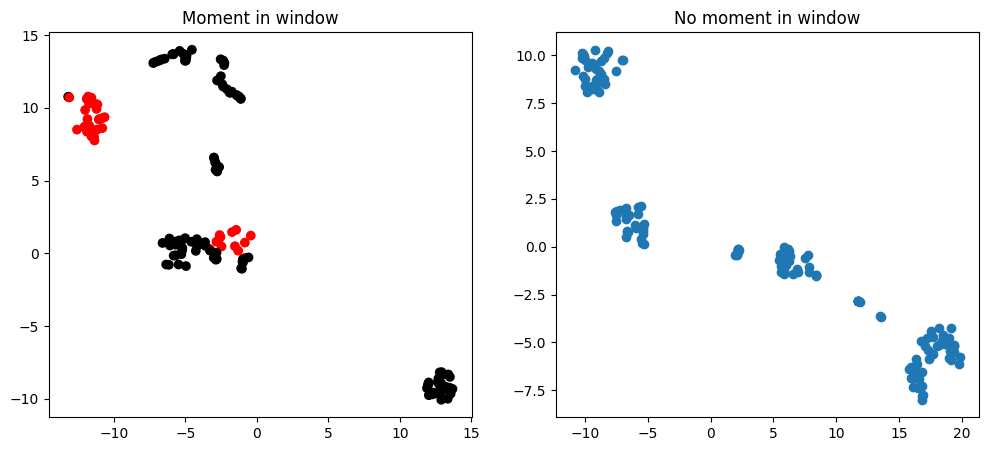

In [200]:
from sklearn.manifold import TSNE

# Your data
foreground_window_idx = topk_target['is_foreground'].argmax().item()
background_window_idx = topk_target['is_foreground'].argmin().item()

# Perform t-SNE on the flattened data
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(topk_movie[foreground_window_idx])
background_data_tsne = tsne.fit_transform(topk_movie[background_window_idx])

# Plot the t-SNE output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
foreground_dot = ax1.scatter(data_tsne[:, 0], data_tsne[:, 1], c=list(map(lambda x: 'red' if x else 'black', foreground)))
ax1.set_title('Moment in window')

background_dot = ax2.scatter(background_data_tsne[:, 0], background_data_tsne[:, 1])
ax2.set_title('No moment in window')



In [8]:
sims

tensor([0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067, 0.0067,
        0.0067])